# TD법으로 정책 평가하기
## TD법 구현

In [1]:
import numpy as np
from collections import defaultdict

class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4
        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}

        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V
        self.V[state] += (target - self.V[state]) * self.alpha

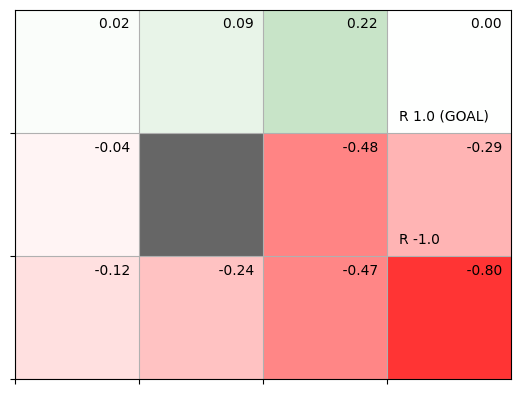

In [2]:
from common.gridworld import GridWorld

env = GridWorld()
agent = TdAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.eval(state, reward, next_state, done)
        if done:
            break
        state = next_state
env.render_v(agent.V)        

## SARSA

## SARSA 구현

In [3]:
from collections import defaultdict, deque
import numpy as np
from common.utils import greedy_probs

class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions,p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return
        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        next_q = 0 if done else self.Q[next_state, next_action]
        target = reward + self.gamma*next_q
        self.Q[state, action] += (target -self.Q[state, action]) * self.alpha
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

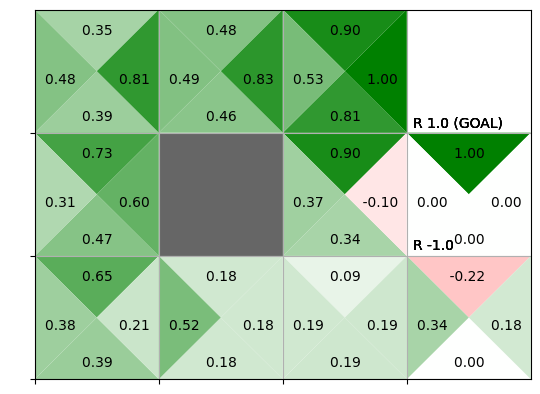

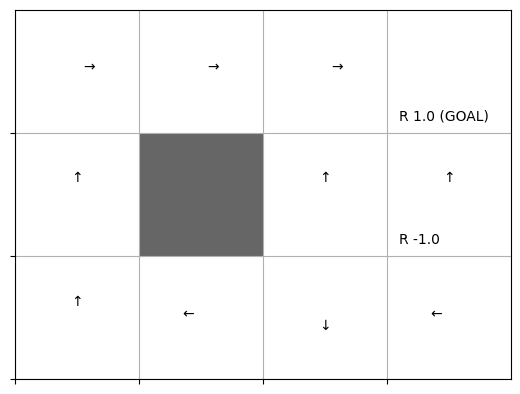

In [4]:
from common.gridworld import GridWorld

env = GridWorld()
agent = SarsaAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()
    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, done)
        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state
env.render_q(agent.Q)

# 오프-정책 SARSA

## 오프-정책 SARSA 구현

In [10]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)
        
    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def reset(self):
        self.memory.clear()
        
    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory)<2:
            return
        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        
        rho = 1
        
        if done:
            next_q = 0
            roh = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]
        
        target = rho*(reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        
        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

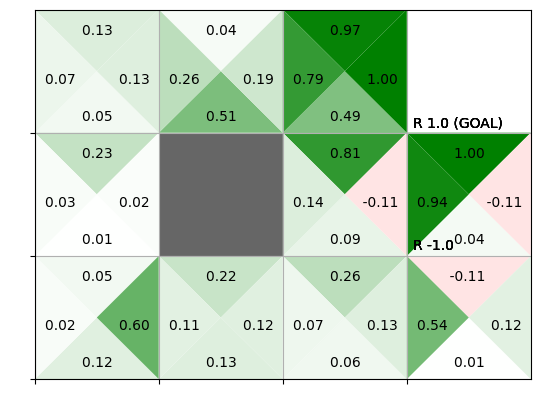

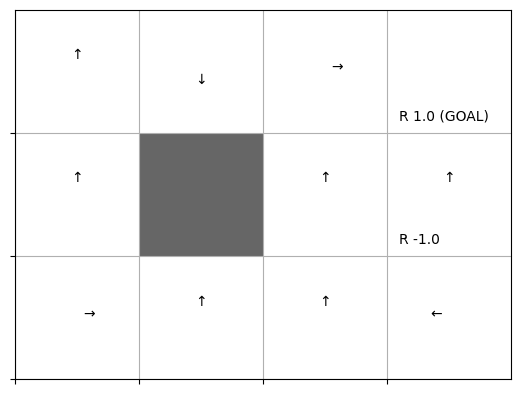

In [11]:
from common.gridworld import GridWorld

env = GridWorld()
agent = SarsaOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()
    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, done)
        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state
env.render_q(agent.Q)

# Q러닝